# Is it a school...? Is it a mall?

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

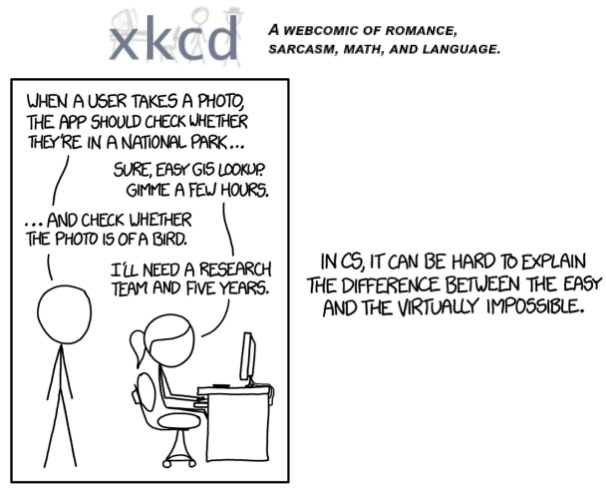

In a previous role of mine, we used to often look at "Demand Maps". A demand map is a visualization of building energy consumption over time. After looking at probably thousands of these, my peers and I became very good at identifying the building type just by looking at it's demand map. After the first few lessons of the fast.ai course, I figured this would be a decent dataset to use for a computer vision model.

## Step 1: Download and visualize building energy patterns

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from fastcore.all import *
from fastai.vision.all import *

In [3]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

my_config = Config(signature_version=UNSIGNED, region_name='us-west-2')
s3 = boto3.client('s3', config=my_config)

In [4]:
# Get Comstock timeseries files
bucket_name = "oedi-data-lake"
prefixes = ["nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/timeseries_aggregates/by_state/upgrade=0/",
            "nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/timeseries_aggregates/by_state/upgrade=28/",
            "nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/comstock_amy2018_release_1/timeseries_aggregates/by_state/upgrade=31/",]

all_files = []
for prefix in prefixes:
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    if 'Contents' in response:
        files = [item['Key'] for item in response['Contents']]
        files = [x for x in files if x[-4:]=='.csv']

    else:
        print("No files found in the specified prefix.")
    
    all_files = all_files + files

We'll leverage the ComStock dataset from NREL to get a collection of energy consumption datasets with known building types. We'll create demand map visualizations for each of these energy consumption datasets. These will be the images we pass into our learner.

In [5]:
path = Path('building_types')

for file in tqdm(all_files):
    
    # building types and filenames
    bldg_name = file.split('/')[-1][:-4]
    bldg_type = bldg_name.split('-')[-1]
    #mapped_bldg_type = bldg_type_mappings[bldg_type]

    o = bldg_type
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    
    # get data
    url = f'https://oedi-data-lake.s3.amazonaws.com/{file}'
    df = pd.read_csv(url)
    
    # plot data
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.strftime('%H:%M')

    energy_pivot = df.pivot(index='date', columns='time', values='out.site_energy.total.energy_consumption.kwh')
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(energy_pivot, cmap='turbo', cbar=False)
    plt.axis('off')

    plt.savefig(dest/f"{bldg_name}.png")
    plt.close()

100%|██████████| 996/996 [51:33<00:00,  3.11s/it]  


Let's take a look at a sample:

building_types/retailstripmall/up31-mn-retailstripmall.png


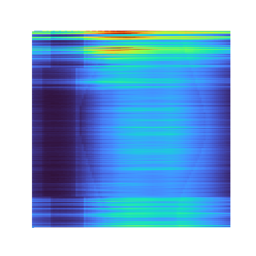

In [6]:
print(dest/f"{bldg_name}.png")
im = Image.open(dest/f"{bldg_name}.png")
im.to_thumb(256,256)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training).

In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

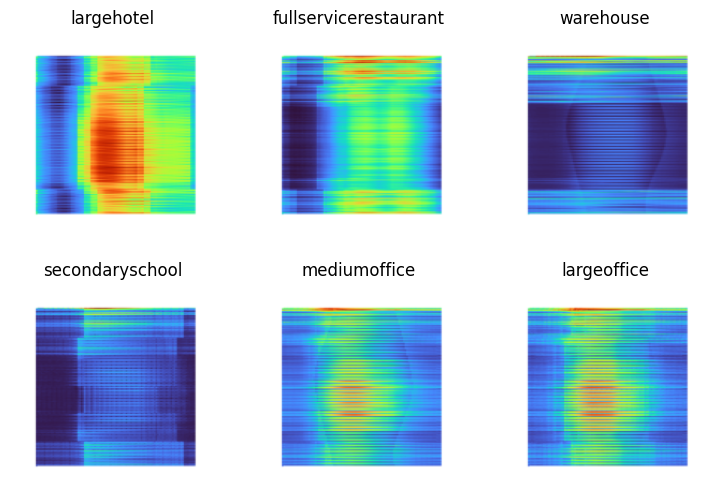

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.652903,0.623930,0.231156,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.604674,0.277861,0.085427,00:13
1,0.407177,0.161019,0.045226,00:13
2,0.279588,0.096569,0.030151,00:13
3,0.184417,0.084108,0.020101,00:14
4,0.139206,0.221815,0.045226,00:13
5,0.110090,0.109843,0.020101,00:14
6,0.080994,0.093151,0.020101,00:13
7,0.059067,0.076494,0.010050,00:13
8,0.043282,0.079201,0.010050,00:14
9,0.030724,0.075540,0.010050,00:13


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories)

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

building_types/smallhotel/up00-ma-smallhotel.png


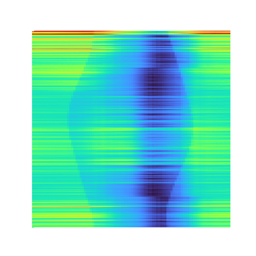

In [10]:
dest = (path/'smallhotel/up00-ma-smallhotel.png')
print(dest)
im = Image.open(dest)
im.to_thumb(256,256)

In [11]:
learn.predict(PILImage.create(dest))

('smallhotel',
 tensor(11),
 tensor([4.5681e-07, 4.9008e-05, 3.0766e-05, 2.5641e-06, 5.5305e-08, 9.3590e-07,
         7.9940e-07, 4.5394e-06, 4.3848e-06, 1.4135e-04, 1.1091e-06, 9.9964e-01,
         9.2999e-07, 1.2642e-04]))

building_types/secondaryschool/up28-ky-secondaryschool.png


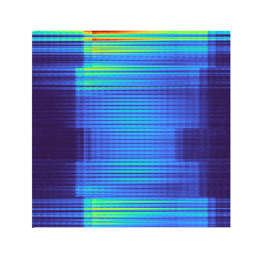

In [12]:
dest = (path/'secondaryschool/up28-ky-secondaryschool.png')
print(dest)
im = Image.open(dest)
im.to_thumb(256,256)

In [13]:
learn.predict(PILImage.create(dest))

('secondaryschool',
 tensor(10),
 tensor([8.2826e-07, 7.4972e-08, 1.1915e-07, 1.7659e-07, 1.7000e-06, 1.7522e-05,
         3.1375e-05, 6.9876e-06, 6.5647e-06, 1.4837e-06, 9.9993e-01, 3.7241e-07,
         4.0150e-07, 8.0791e-08]))

building_types/fullservicerestaurant/up31-ca-fullservicerestaurant.png


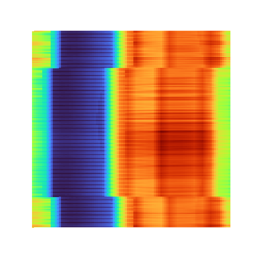

In [14]:
dest = (path/'fullservicerestaurant/up31-ca-fullservicerestaurant.png')
print(dest)
im = Image.open(dest)
im.to_thumb(256,256)

In [15]:
learn.predict(PILImage.create(dest))

('fullservicerestaurant',
 tensor(0),
 tensor([9.9974e-01, 1.1512e-05, 6.7697e-06, 5.0768e-08, 8.6139e-09, 2.1926e-07,
         1.4343e-06, 1.9412e-04, 6.4231e-07, 1.5738e-05, 9.9496e-07, 4.5148e-06,
         3.4488e-07, 2.1255e-05]))

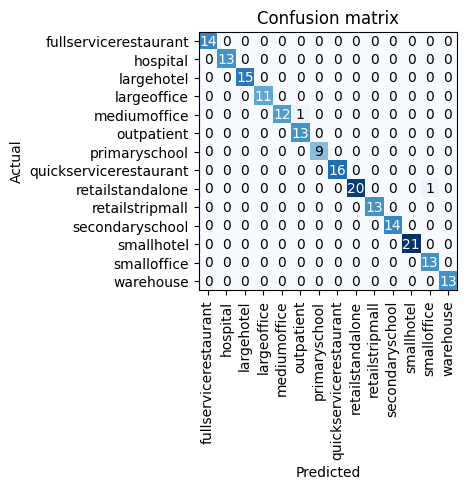

In [16]:
# Where are we missing
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It looks like we only miss a Medium Office that should be Outpatient and a Retail Standalone that should be a Small Office. I'll take it, Good job, resnet18! :)